In [1]:
import torchvision
from torchvision import transforms
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np

from Helper import load_checkpoint_generic, save_checkpoint_generic
from Model import FlyingChairsDataset, MPISintelDataset
from Model import FlowNet



In [2]:
# root = r"C:\Users\simon\Desktop\RV\Racunalniski Vid\RV-N3\datasets\FlyingChairs_release"
root = r"E:\datasets\FlyingChairs_release"

# transform = transforms.ToTensor()
# transform = None
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = FlyingChairsDataset(root=root, transform=transform, split="train")
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

imgs, flows = next(iter(loader))
print(imgs.shape, flows.shape)


torch.Size([16, 6, 256, 256]) torch.Size([16, 2, 256, 256])


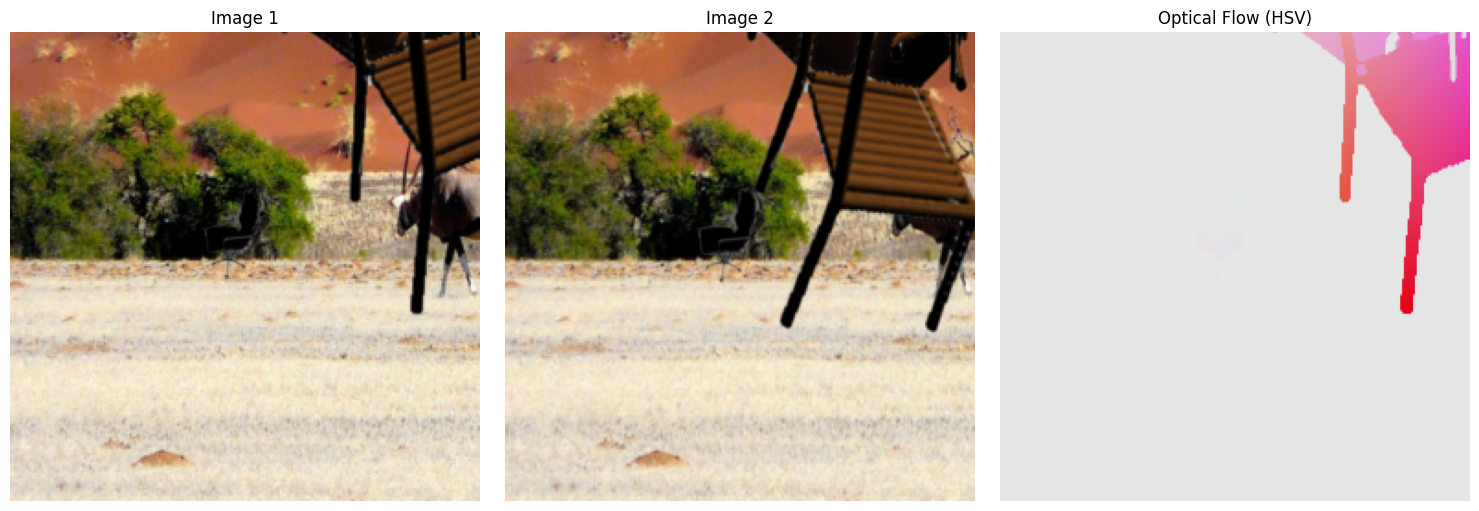

In [3]:
imgs, flows = next(iter(loader))

# Extract first sample from batch
img_pair = imgs[0]  # Shape: (6, H, W)
flow = flows[0]  # Shape: (2, H, W)

# Split the 6-channel image into two 3-channel images
img1 = img_pair[:3].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
img2 = img_pair[3:].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)

# Convert flow to numpy (H, W, 2)
flow_np = flow.permute(1, 2, 0).cpu().numpy()

# Split flow components
u = flow_np[:, :, 0]
v = flow_np[:, :, 1]

# Magnitude and angle
mag = np.sqrt(u ** 2 + v ** 2)
ang = np.arctan2(v, u)  # [-pi, pi]

# Normalize for HSV
h = (ang + np.pi) / (2 * np.pi)  # hue ∈ [0,1]
s = np.clip(mag / (mag.max() + 1e-6), 0, 1)  # saturation ∈ [0,1]
v_ = np.ones_like(s) * 0.9  # brightness

# Build HSV image
hsv = np.stack([h, s, v_], axis=-1)
rgb_flow = mcolors.hsv_to_rgb(hsv)

# Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image 1")
plt.imshow(img1)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Image 2")
plt.imshow(img2)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Optical Flow (HSV)")
plt.imshow(rgb_flow)
plt.axis("off")

plt.tight_layout()
plt.show()

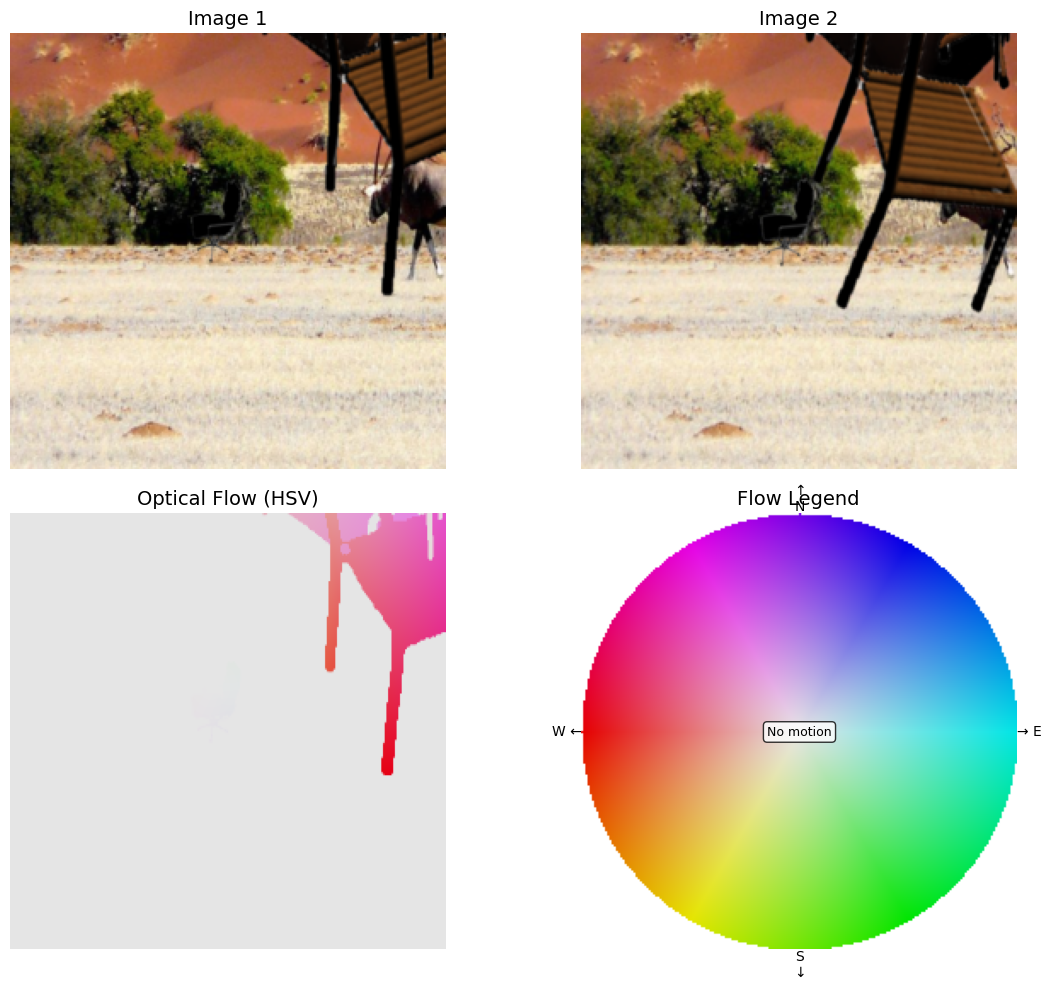

Flow magnitude range: [0.04, 69.70] pixels
Mean flow magnitude: 3.32 pixels


In [4]:
# Extract first sample from batch
img_pair = imgs[0]
flow = flows[0]

# Split images and convert to numpy
img1 = img_pair[:3].permute(1, 2, 0).cpu().numpy()
img2 = img_pair[3:].permute(1, 2, 0).cpu().numpy()
flow_np = flow.permute(1, 2, 0).cpu().numpy()

# Split flow components
u = flow_np[:, :, 0]
v = flow_np[:, :, 1]

# Magnitude and angle
mag = np.sqrt(u ** 2 + v ** 2)
ang = np.arctan2(v, u)

# Normalize for HSV
h = (ang + np.pi) / (2 * np.pi)
s = np.clip(mag / (mag.max() + 1e-6), 0, 1)
v_ = np.ones_like(s) * 0.9

# Build HSV image
hsv = np.stack([h, s, v_], axis=-1)
rgb_flow = mcolors.hsv_to_rgb(hsv)


# --- Create colorwheel legend ---
def make_colorwheel(size=256):
    """Create a colorwheel showing flow direction and magnitude"""
    y, x = np.mgrid[-size // 2:size // 2, -size // 2:size // 2]

    angle = np.arctan2(-y, x)
    radius = np.sqrt(x ** 2 + y ** 2)

    hue = (angle + np.pi) / (2 * np.pi)
    saturation = np.clip(radius / (size // 2), 0, 1)
    value = np.ones_like(saturation) * 0.9

    hsv_wheel = np.stack([hue, saturation, value], axis=-1)
    rgb_wheel = mcolors.hsv_to_rgb(hsv_wheel)

    mask = radius > (size // 2)
    rgb_wheel[mask] = 1

    return rgb_wheel


colorwheel = make_colorwheel(200)

# --- Plot in 2 rows ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# First row: images
axes[0, 0].set_title("Image 1", fontsize=14)
axes[0, 0].imshow(img1)
axes[0, 0].axis("off")

axes[0, 1].set_title("Image 2", fontsize=14)
axes[0, 1].imshow(img2)
axes[0, 1].axis("off")

# Second row: flow and legend
axes[1, 0].set_title("Optical Flow (HSV)", fontsize=14)
axes[1, 0].imshow(rgb_flow)
axes[1, 0].axis("off")

axes[1, 1].set_title("Flow Legend", fontsize=14)
axes[1, 1].imshow(colorwheel)
axes[1, 1].axis("off")

# Add text annotations to legend
axes[1, 1].text(200, 100, "→ E", ha='left', va='center', fontsize=10, color='black')
axes[1, 1].text(0, 100, "W ←", ha='right', va='center', fontsize=10, color='black')
axes[1, 1].text(100, 0, "↑\nN", ha='center', va='bottom', fontsize=10, color='black')
axes[1, 1].text(100, 200, "S\n↓", ha='center', va='top', fontsize=10, color='black')
axes[1, 1].text(100, 100, "No motion", ha='center', va='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print flow statistics
print(f"Flow magnitude range: [{mag.min():.2f}, {mag.max():.2f}] pixels")
print(f"Mean flow magnitude: {mag.mean():.2f} pixels")

In [5]:
# Visualization function for predicted flow
def visualize_flow_prediction(model, dataset, idx=0, device='cpu'):
    """
    Visualize model's flow prediction
    """
    model.eval()
    model = model.to(device)

    # Get data (dataset returns img_pair, flow_gt)
    img_pair, flow_gt = dataset[idx]

    # Split concatenated images
    img1 = img_pair[:3]  # First 3 channels
    img2 = img_pair[3:]  # Last 3 channels

    # Add batch dimension and move to device
    img_pair_batch = img_pair.unsqueeze(0).to(device)

    # Predict flow
    with torch.no_grad():
        flow_preds = model(img_pair_batch)
        flow_pred = flow_preds[0]  # Get full resolution prediction

    # Convert to numpy
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    flow_gt_np = flow_gt.permute(1, 2, 0).cpu().numpy()
    flow_pred_np = flow_pred[0].permute(1, 2, 0).cpu().numpy()

    # Visualize using HSV color coding
    def flow_to_hsv(flow):
        u = flow[:, :, 0]
        v = flow[:, :, 1]

        mag = np.sqrt(u ** 2 + v ** 2)
        ang = np.arctan2(v, u)

        h = (ang + np.pi) / (2 * np.pi)
        s = np.clip(mag / (mag.max() + 1e-6), 0, 1)
        v_ = np.ones_like(s)

        hsv = np.stack([h, s, v_], axis=-1)
        return mcolors.hsv_to_rgb(hsv)

    flow_gt_hsv = flow_to_hsv(flow_gt_np)
    flow_pred_hsv = flow_to_hsv(flow_pred_np)

    # Compute endpoint error
    epe = np.linalg.norm(flow_pred_np - flow_gt_np, axis=2).mean()

    # Plot
    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.title("Image 1")
    plt.imshow(img1_np)
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.title("Image 2")
    plt.imshow(img2_np)
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.title("Ground Truth Flow")
    plt.imshow(flow_gt_hsv)
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.title(f"Predicted Flow (EPE: {epe:.2f})")
    plt.imshow(flow_pred_hsv)
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.title("Error Map")
    error_map = np.linalg.norm(flow_pred_np - flow_gt_np, axis=2)
    plt.imshow(error_map, cmap='hot')
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Average Endpoint Error: {epe:.4f} pixels")
    return epe


Loaded model from iteration 494300
Val Loss: 3.0368, Val EPE: 2.2944


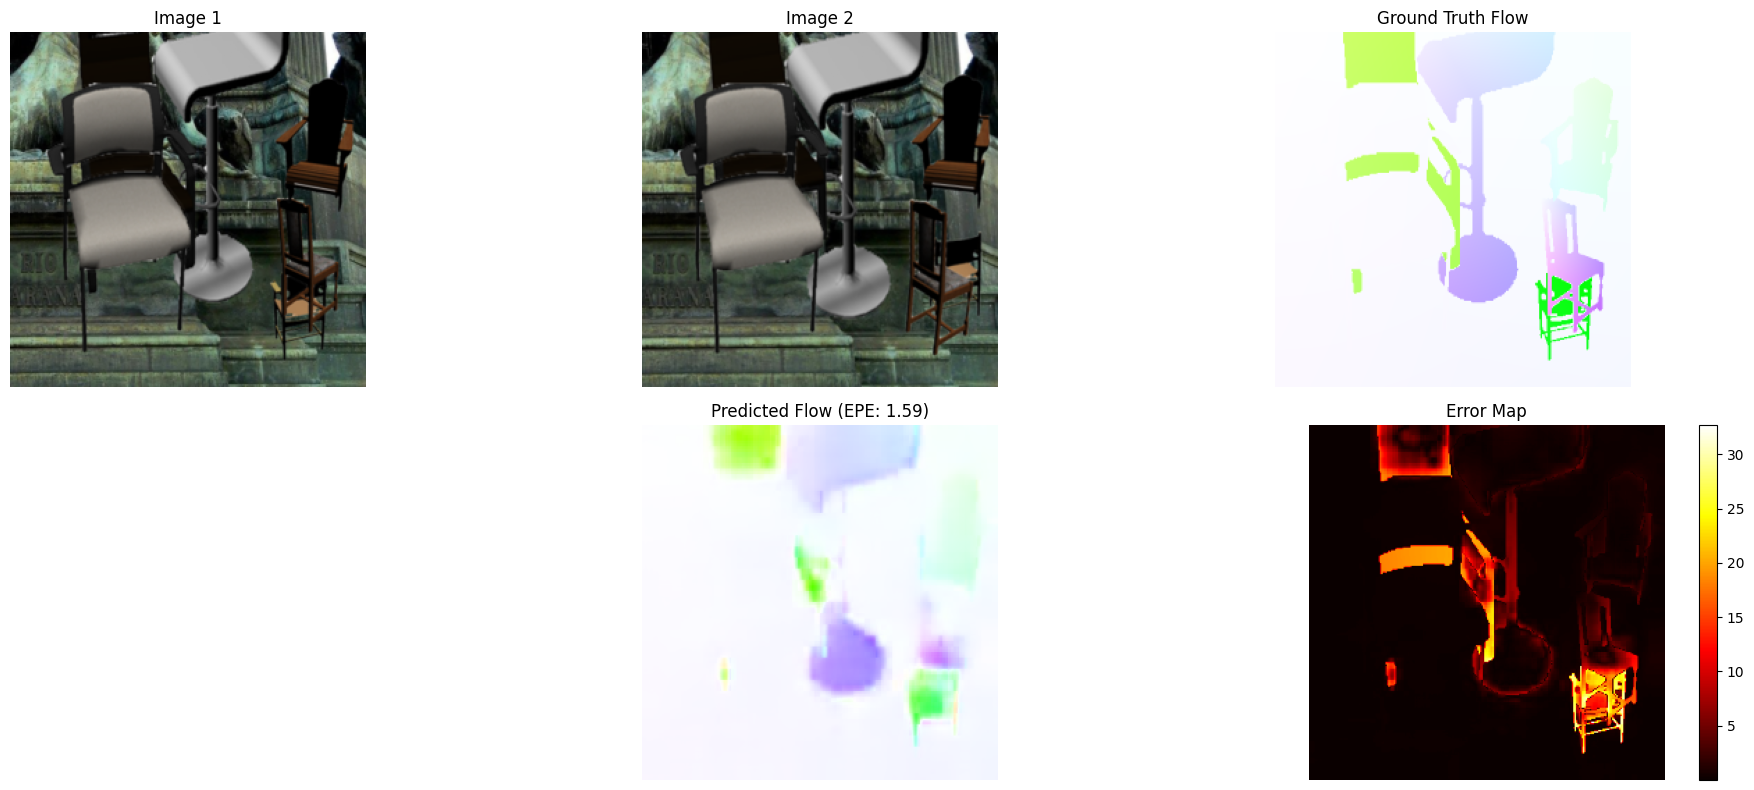

Average Endpoint Error: 1.5891 pixels


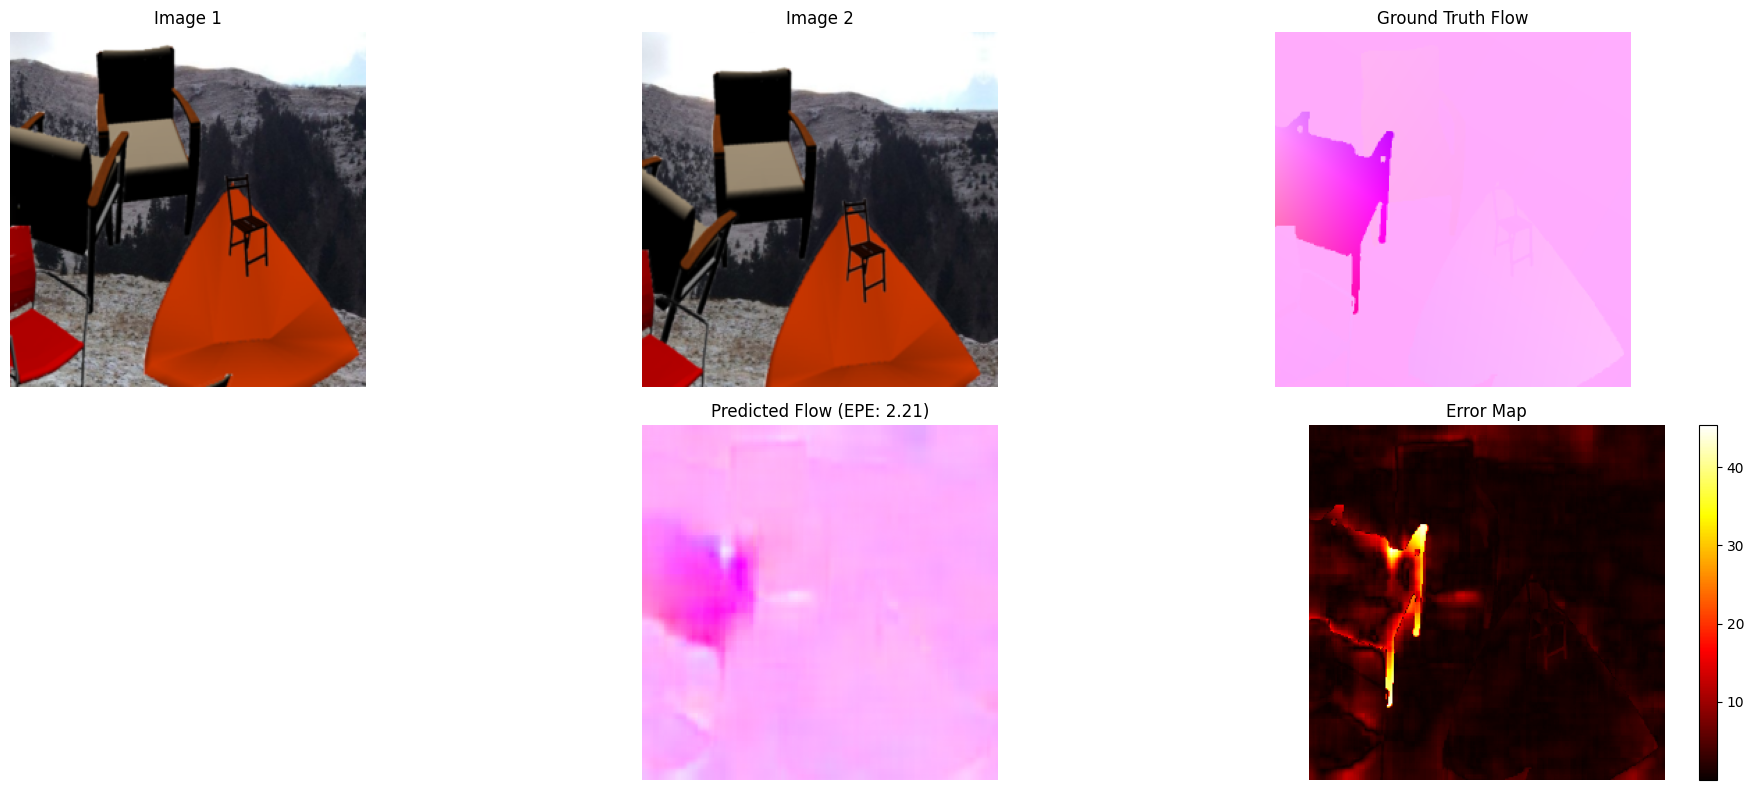

Average Endpoint Error: 2.2060 pixels


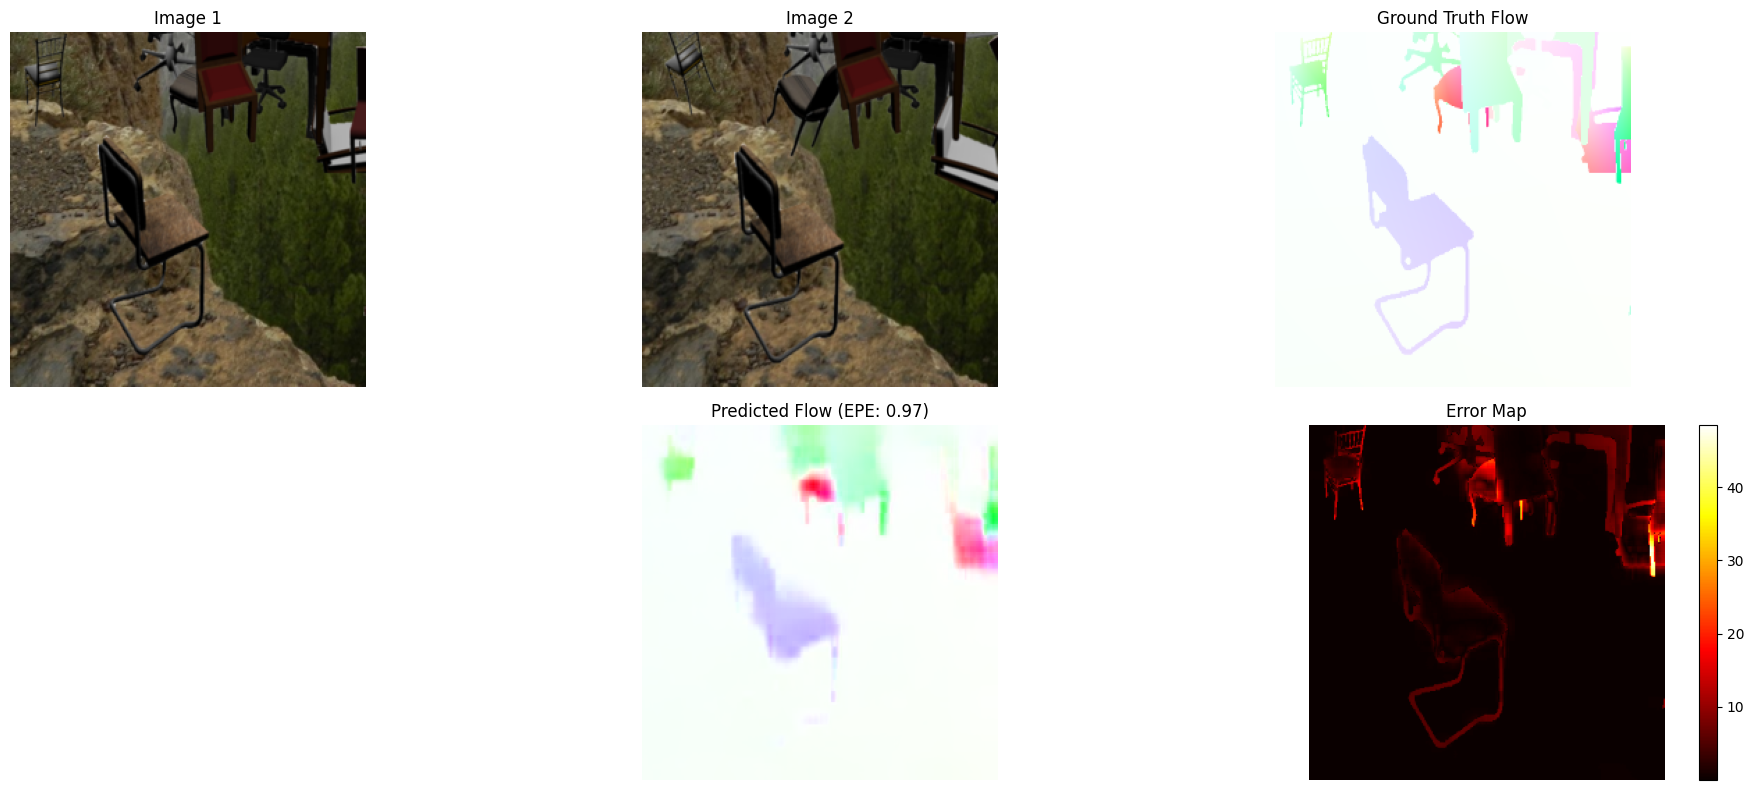

Average Endpoint Error: 0.9745 pixels


np.float32(0.9744773)

In [6]:
root = r"E:\datasets\FlyingChairs_release"
checkpoint_dir = Path('./checkpoints')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = FlyingChairsDataset(root=root, transform=transform, split="train")

# Cell: Load best model and visualize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FlowNet().to(device)

best_model_path = checkpoint_dir / 'best_flownet_model.pth'
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from iteration {checkpoint['iteration']}")
print(f"Val Loss: {checkpoint['val_loss']:.4f}, Val EPE: {checkpoint['val_epe']:.4f}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Visualize predictions
visualize_flow_prediction(model, dataset, idx=random.randint(5, dataset.__len__()), device=device)
visualize_flow_prediction(model, dataset, idx=random.randint(5, dataset.__len__()), device=device)
visualize_flow_prediction(model, dataset, idx=random.randint(5, dataset.__len__()), device=device)

In [7]:
def plot_flow_data(img_data, flow_ref_data, flow_est_data=None):
    """
    Izris slik in optičnih pretokov na različnih nivojih.
    """
    img_cur = img_data[0, :3, :, :].detach().cpu().numpy().transpose(1, 2, 0)
    img_next = img_data[0, 3:, :, :].detach().cpu().numpy().transpose(1, 2, 0)

    # Izris slik
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(img_cur)
    ax[0].set_axis_off()
    ax[0].set_title('Trenutna slika')
    ax[1].imshow(img_next)
    ax[1].set_title('Naslednja slika')
    ax[1].set_axis_off()
    plt.tight_layout()
    plt.show()

    # Pripravi podatke za izris
    if flow_est_data is not None:
        n_rows = len(flow_ref_data)
        fig, ax = plt.subplots(n_rows, 2, squeeze=False, figsize=(12, 4 * n_rows))
        ax_data_pack = [
            (ax[:, 0], flow_ref_data, 'Ground Truth'),
            (ax[:, 1], flow_est_data, 'Predicted')
        ]
    else:
        n_rows = len(flow_ref_data)
        fig, ax = plt.subplots(n_rows, 1, squeeze=False, figsize=(6, 4 * n_rows))
        ax_data_pack = [(ax[:, 0], flow_ref_data, 'Ground Truth')]

    # Izris pretokov z 'nearest' interpolacijo
    for ax_list, flow_data, label in ax_data_pack:
        for n, f_img in enumerate(flow_data):
            f_img_viz = torchvision.utils.flow_to_image(f_img[0].detach().cpu())
            f_img_viz = f_img_viz.numpy().transpose(1, 2, 0)

            # Ključno: interpolation='nearest' za blokast izgled
            ax_list[n].imshow(f_img_viz, interpolation='nearest')
            ax_list[n].set_axis_off()

            h, w = f_img_viz.shape[:2]
            level = len(flow_data) - n
            ax_list[n].set_title(f'{label} - nivo {level}, ločljivost ({h}, {w})')

    plt.tight_layout()
    plt.show()


Sample 1/2 (dataset index: 10113)


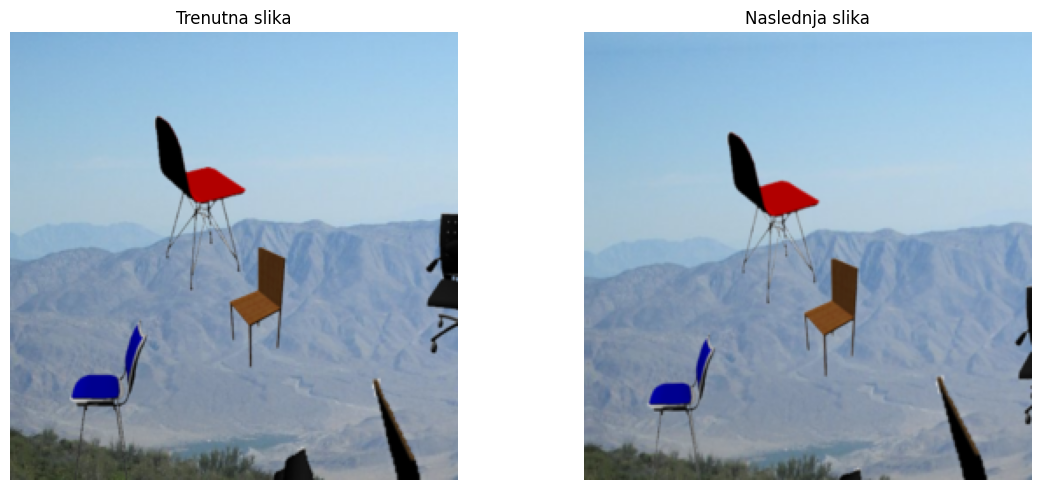

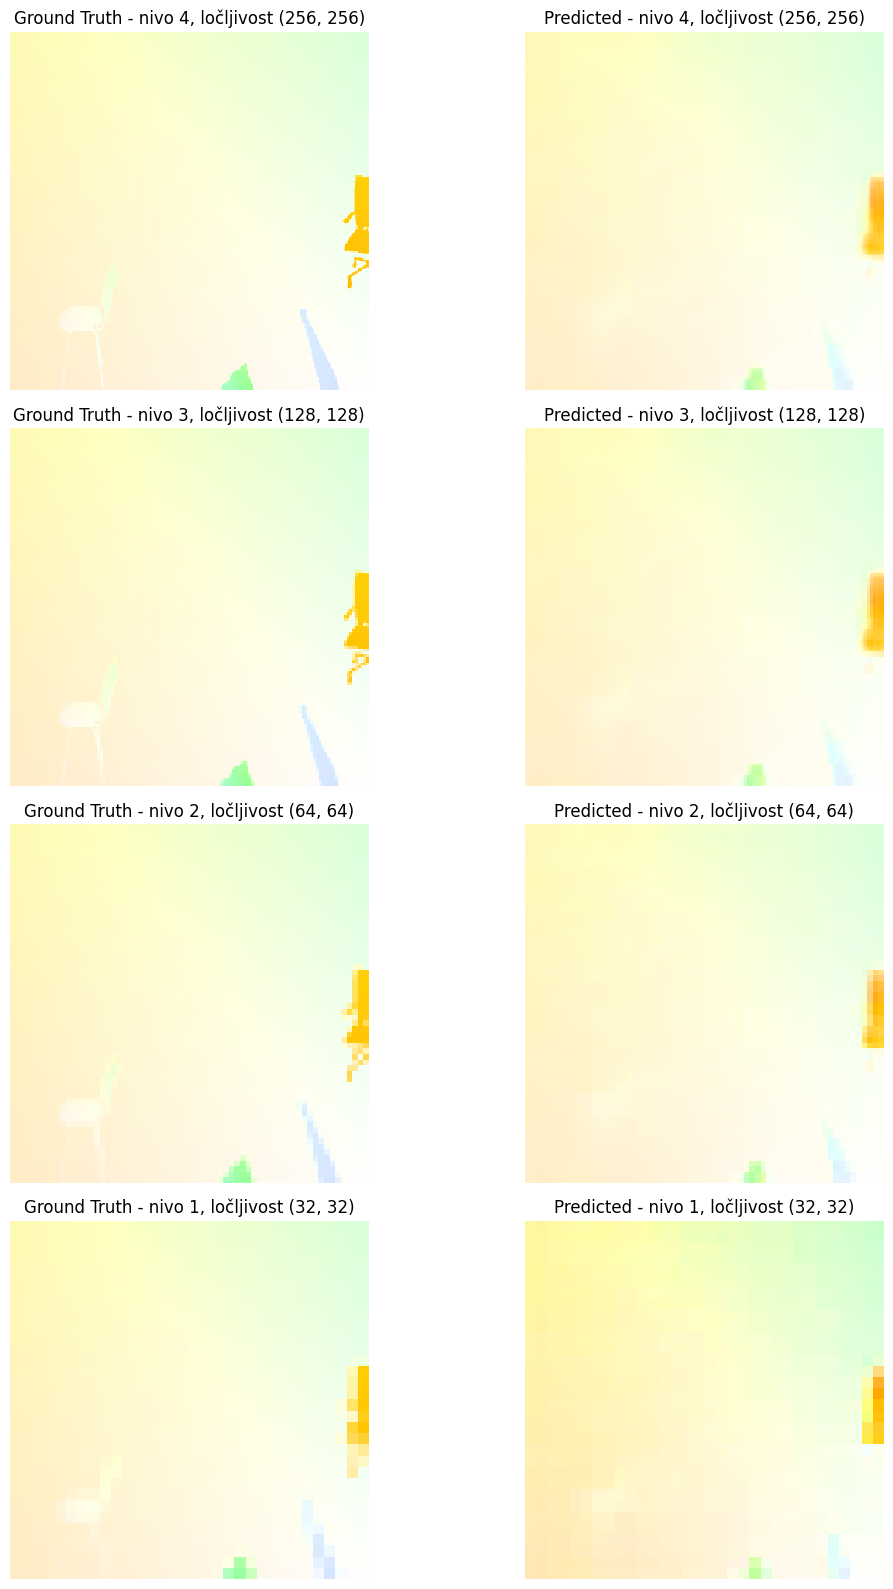


Sample 2/2 (dataset index: 14743)


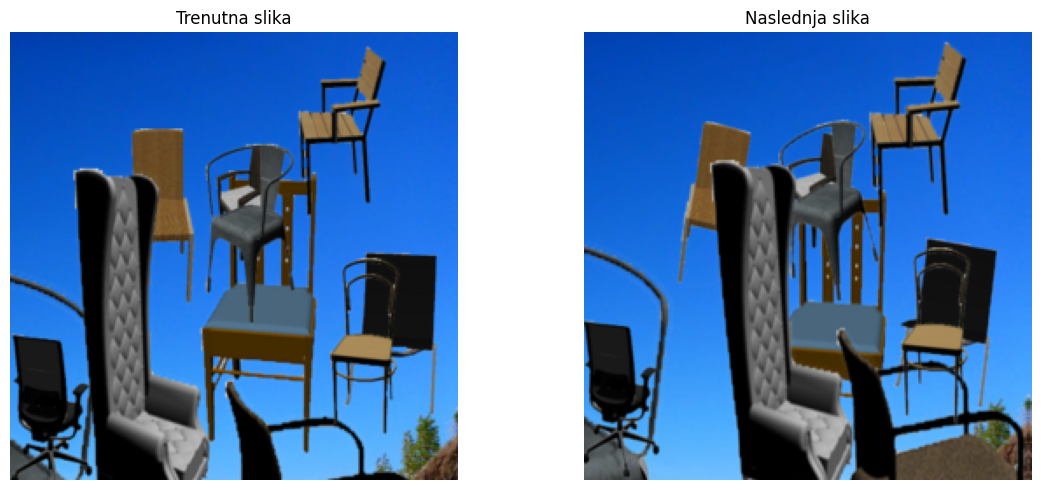

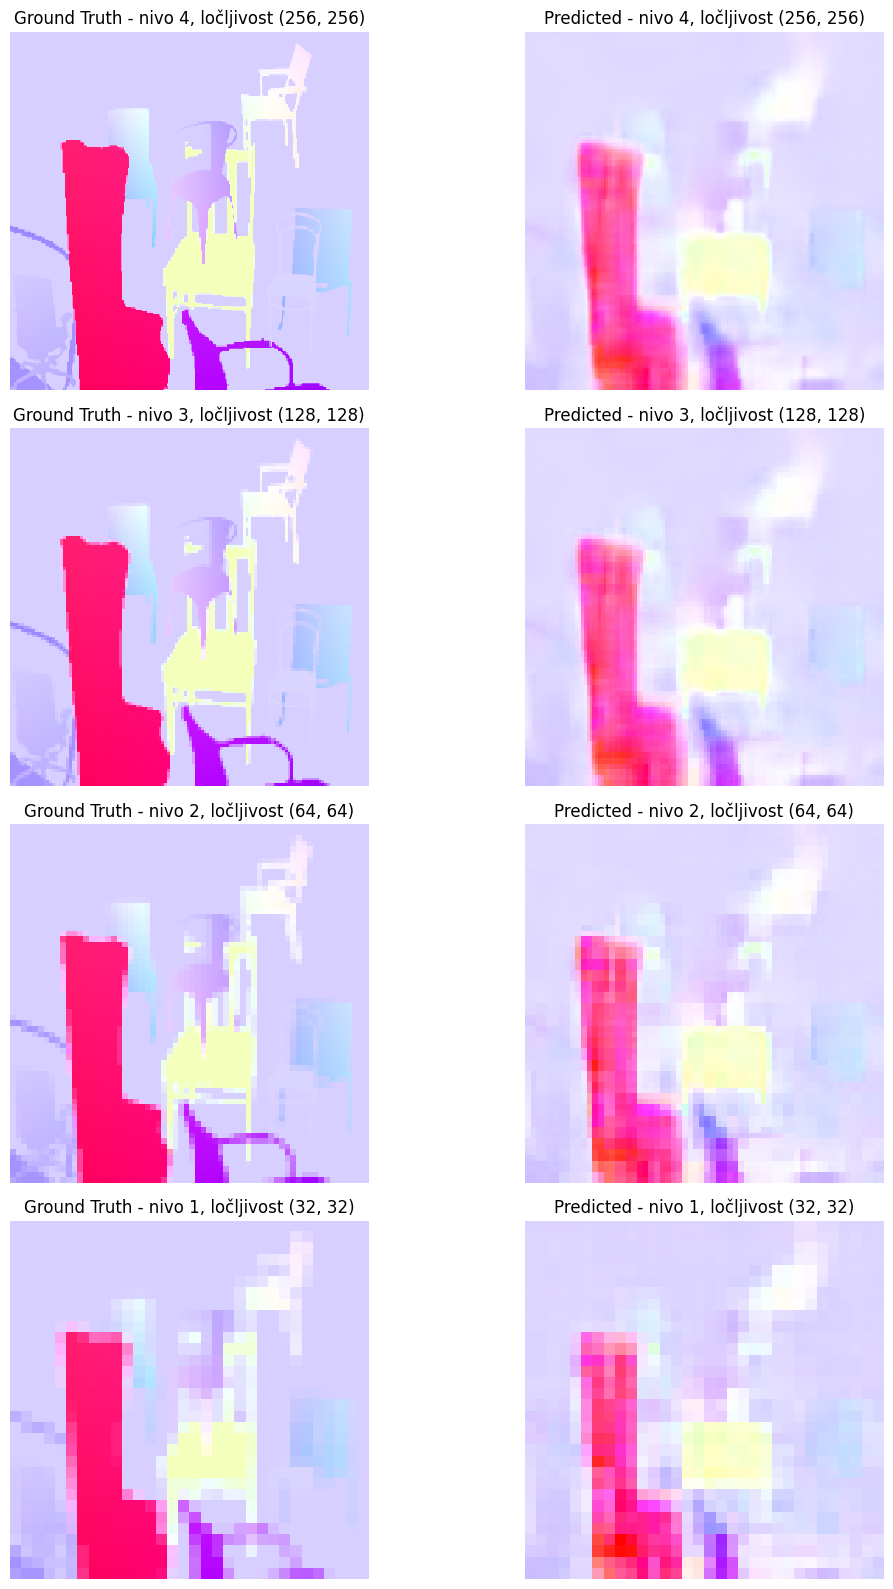

In [8]:
# Število random vzorcev za izris
n_samples = 2

for i in range(n_samples):
    # Pridobi random indeks
    random_idx = random.randint(0, len(dataset) - 1)
    print(f"\n{'=' * 60}")
    print(f"Sample {i + 1}/{n_samples} (dataset index: {random_idx})")
    print(f"{'=' * 60}")

    # Naloži podatke
    img_pair, flow_gt = dataset[random_idx]
    img_pair = img_pair.unsqueeze(0).to(device)
    flow_gt = flow_gt.unsqueeze(0).to(device)

    # Napoved
    model.eval()
    with torch.no_grad():
        flow1, flow2, flow3, flow4 = model(img_pair)

    # Pripravi GT na različnih nivojih (z area pooling)
    h, w = flow_gt.shape[2:]
    flow_gt_2 = F.interpolate(flow_gt, size=(h // 2, w // 2), mode='area')
    flow_gt_3 = F.interpolate(flow_gt, size=(h // 4, w // 4), mode='area')
    flow_gt_4 = F.interpolate(flow_gt, size=(h // 8, w // 8), mode='area')

    flow_gts = [flow_gt, flow_gt_2, flow_gt_3, flow_gt_4]
    flow_preds = [flow1, flow2, flow3, flow4]

    # Izris
    plot_flow_data(img_pair, flow_gts, flow_preds)

In [9]:
import torchinfo

# Cell: Load best model and visualize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FlowNet().to(device)

# checkpoint_dir = Path('./checkpoints')
# best_model_path = checkpoint_dir / 'best_flownet_model.pth'
# checkpoint = torch.load(best_model_path, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# print(f"Loaded model from iteration {checkpoint['iteration']}")
# print(f"Val Loss: {checkpoint['val_loss']:.4f}, Val EPE: {checkpoint['val_epe']:.4f}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

torchinfo.summary(model, depth=4)


Layer (type:depth-idx)                   Param #
FlowNet                                  --
├─DownBlock: 1-1                         --
│    └─ConvBlock: 2-1                    --
│    │    └─Sequential: 3-1              --
│    │    │    └─Conv2d: 4-1             18,880
│    │    │    └─BatchNorm2d: 4-2        128
│    │    │    └─ReLU: 4-3               --
│    └─ConvBlock: 2-2                    --
│    │    └─Sequential: 3-2              --
│    │    │    └─Conv2d: 4-4             200,768
│    │    │    └─BatchNorm2d: 4-5        128
│    │    │    └─ReLU: 4-6               --
│    └─MaxPool2d: 2-3                    --
├─DownBlock: 1-2                         --
│    └─ConvBlock: 2-4                    --
│    │    └─Sequential: 3-3              --
│    │    │    └─Conv2d: 4-7             204,928
│    │    │    └─BatchNorm2d: 4-8        256
│    │    │    └─ReLU: 4-9               --
│    └─ConvBlock: 2-5                    --
│    │    └─Sequential: 3-4              --
│    │    

In [10]:
def migrate_checkpoint_remove_bottleneck(old_checkpoint_dir, new_checkpoint_dir, lr=1e-4):
    """
    Naloži najnovejši checkpoint, odstrani bottleneck uteži,
    ustvari nov optimizer, shrani v nov direktorij.
    """
    import torch
    import torch.optim as optim
    from Model import FlowNet
    from Helper import load_checkpoint_generic, save_checkpoint_generic
    import os

    # 1. Load latest checkpoint
    print(f"📂 Loading from: {old_checkpoint_dir}")
    checkpoint = load_checkpoint_generic(old_checkpoint_dir, device='cpu')

    if not checkpoint:
        print("❌ No checkpoint found to migrate!")
        return None

    # 2. Extract model state_dict
    old_state = checkpoint['model_state_dict']

    # 3. Create new model and filter weights
    new_model = FlowNet()
    new_state = new_model.state_dict()

    # Filter: remove b1, b2 bottleneck layers
    migrated = {}
    skipped = []

    for k, v in old_state.items():
        if k.startswith('b1.') or k.startswith('b2.'):
            skipped.append(k)
            continue

        if k in new_state and v.shape == new_state[k].shape:
            migrated[k] = v
        else:
            skipped.append(k)

    # 4. Load migrated weights into new model
    new_state.update(migrated)
    new_model.load_state_dict(new_state)

    # 5. ✅ CREATE NEW OPTIMIZER for the new model
    new_optimizer = optim.Adam(new_model.parameters(), lr=lr)
    print(f"✅ Created new optimizer with lr={lr}")

    # 6. Create new checkpoint preserving ALL training data
    new_checkpoint = {
        'iteration': checkpoint.get('iteration', 0),
        'model_state_dict': new_model.state_dict(),
        'optimizer_state_dict': new_optimizer.state_dict(),  # ✅ NEW optimizer
        'lr': checkpoint.get('lr', lr),
        'best_val_loss': checkpoint.get('best_val_loss', float('inf')),
        'val_losses': checkpoint.get('val_losses', []),
        'val_epes': checkpoint.get('val_epes', []),
        'iterations_log': checkpoint.get('iterations_log', []),
        'train_losses': checkpoint.get('train_losses', [])
    }

    # 7. Create output directory if needed
    os.makedirs(new_checkpoint_dir, exist_ok=True)

    # 8. Save using your helper function
    iteration = checkpoint.get('iteration', 0)
    save_checkpoint_generic(new_checkpoint_dir, iteration, new_checkpoint, max_checkpoints=5)

    # 9. Report
    print(f"\n✅ Migrated {len(migrated)}/{len(old_state)} weights")
    print(f"⚠️  Skipped {len(skipped)} parameters (bottleneck layers)")
    print(f"\n📊 Preserved metadata:")
    print(f"  - iteration: {new_checkpoint['iteration']}")
    print(f"  - lr: {new_checkpoint['lr']}")
    print(f"  - best_val_loss: {new_checkpoint['best_val_loss']:.6f}")
    print(f"  - val_losses: {len(new_checkpoint['val_losses'])} entries")
    print(f"  - val_epes: {len(new_checkpoint['val_epes'])} entries")
    print(f"  - iterations_log: {len(new_checkpoint['iterations_log'])} entries")
    print(f"  - train_losses: {len(new_checkpoint['train_losses'])} entries")
    print(f"\n✅ Optimizer state CREATED and saved (ready for training resume)")

    return new_model


# model = migrate_checkpoint_remove_bottleneck(
#     old_checkpoint_dir='./checkpoints_bottleneck',
#     new_checkpoint_dir='./checkpoints',
#     lr=1e-4
# )
#
# print("\n🚀 Checkpoint ready! You can now resume training with:")
# print("   checkpoint = load_checkpoint_generic('./checkpoints', device)")

In [11]:
# from Helper import load_checkpoint_generic, save_checkpoint_generic
# from Model import FlowNet
# import torch
# import torch.optim as optim
#
# device = torch.device('cuda')
# model = FlowNet().to(device)
# optimizer = optim.Adam(model.parameters())
#
# # Load checkpoint - everything is ready!
# checkpoint = load_checkpoint_generic('./checkpoints', device)
#
# if checkpoint:
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # ✅ Dela!
#
#     start_iteration = checkpoint['iteration'] + 1
#     current_lr = checkpoint['lr']
#     best_val_loss = checkpoint['best_val_loss']
#     val_losses = checkpoint['val_losses']
#     val_epes = checkpoint['val_epes']
#     iterations_log = checkpoint['iterations_log']
#     train_losses = checkpoint['train_losses']
#
#     print(f"🚀 Resuming from iteration {start_iteration}")
#     print(f"📊 Best validation loss: {best_val_loss:.6f}")
#     print(f"📈 Training history: {len(train_losses)} entries")
# else:
#     start_iteration = 1
#     val_losses = []
#     val_epes = []
#     train_losses = []
#
# print("✅ Ready to train!")

In [12]:
# Cell: Create Best Model from Checkpoint History
from pathlib import Path
import torch
from Helper import load_checkpoint_generic

def create_best_model_from_checkpoint(checkpoint_dir, device='cuda'):
    """
    Load checkpoint history and create best_flownet_model.pth based on
    the lowest validation loss in history.
    """
    checkpoint_dir = Path(checkpoint_dir)

    # Load latest checkpoint (contains full history)
    checkpoint = load_checkpoint_generic(checkpoint_dir, device='cpu')

    if not checkpoint:
        print("❌ No checkpoint found!")
        return None

    # Extract history
    val_losses = checkpoint.get('val_losses', [])
    iterations_log = checkpoint.get('iterations_log', [])
    val_epes = checkpoint.get('val_epes', [])
    val_epes_multiscale = checkpoint.get('val_epes_multiscale', [])

    if not val_losses:
        print("❌ No validation history found in checkpoint!")
        return None

    # Find best validation
    best_idx = val_losses.index(min(val_losses))
    best_val_loss = val_losses[best_idx]
    best_iteration = iterations_log[best_idx]
    best_val_epe = val_epes[best_idx]

    # Get multiscale EPE for best iteration
    if val_epes_multiscale and best_idx < len(val_epes_multiscale):
        best_multiscale = val_epes_multiscale[best_idx]
    else:
        # Fallback if multiscale data missing
        best_multiscale = {
            'epe1': best_val_epe,
            'epe2': 0.0,
            'epe3': 0.0,
            'epe4': 0.0
        }
        print(f"⚠️  No multiscale EPE data for best iteration, using fallback")

    # Create best model checkpoint
    best_model_checkpoint = {
        'iteration': best_iteration,
        'model_state_dict': checkpoint['model_state_dict'],  # Current model weights
        'optimizer_state_dict': checkpoint['optimizer_state_dict'],
        'val_loss': best_val_loss,
        'val_epe': best_val_epe,
        'lr': checkpoint.get('lr', 1e-4),
        'val_epes_multiscale': best_multiscale
    }

    # Save best model
    best_model_path = checkpoint_dir / 'best_flownet_model.pth'
    torch.save(best_model_checkpoint, best_model_path)

    # Print summary
    print("\n" + "="*70)
    print("✅ Created best_flownet_model.pth from checkpoint history")
    print("="*70)
    print(f"📊 Best validation found at:")
    print(f"  - Iteration: {best_iteration:,}")
    print(f"  - Val Loss: {best_val_loss:.6f}")
    print(f"  - Val EPE1: {best_val_epe:.6f}")
    print(f"  - Learning Rate: {best_model_checkpoint['lr']:.6f}")
    print(f"\n📈 Multiscale EPE at best iteration:")
    print(f"  - EPE1 (full res):  {best_multiscale['epe1']:.4f} px")
    print(f"  - EPE2 (1/2 res):   {best_multiscale['epe2']:.4f} px")
    print(f"  - EPE3 (1/4 res):   {best_multiscale['epe3']:.4f} px")
    print(f"  - EPE4 (1/8 res):   {best_multiscale['epe4']:.4f} px")
    print(f"\n💾 Saved to: {best_model_path}")
    print(f"\n📉 Statistics from {len(val_losses)} validation points:")
    print(f"  - Best val loss: {min(val_losses):.6f}")
    print(f"  - Worst val loss: {max(val_losses):.6f}")
    print(f"  - Current val loss: {val_losses[-1]:.6f}")
    print(f"  - Best is at index {best_idx}/{len(val_losses)-1}")
    print("="*70)

    return best_model_checkpoint

# Execute
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# best_model = create_best_model_from_checkpoint('./checkpoints', device=device)